In [111]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [112]:
env = BlackjackEnv()

In [113]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    We pass in a state to this policy to get the action probabilites 
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the dobservation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    
    def policy_fn(observation):
        
        A = np.ones(nA) * epsilon/nA
        best_action = np.argmax(Q[observation])
        A[best_action] += 1 - epsilon
        return A
    
    return policy_fn

In [114]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    

    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for e in range(num_episodes):
        # Evaluate the policy for one episode
        state = env.reset()
        episodes = []
        while True:
            actions = policy(state)
            action_choice = np.random.choice(actions.size,p=actions)
            next_state, reward, done, _ = env.step(action_choice)
            episodes.append((state,reward,action_choice))
            if done:
                break
            state = next_state
        # Calculate G and add it to our estimate of Q for action
        states = set([(episode[0],episode[2]) for episode in episodes])
        for state in states:
            first_index = next(i for i,x in enumerate(episodes) if (x[0],x[2]) == state)
            G = sum([(discount_factor ** i) * state[1] for i,state in enumerate(episodes[first_index:])])
            returns_count[state] += 1
            Q[state[0]][state[1]] = Q[state[0]][state[1]] + (1/returns_count[state]) * (G - Q[state[0]][state[1]])

    return Q, policy

In [115]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

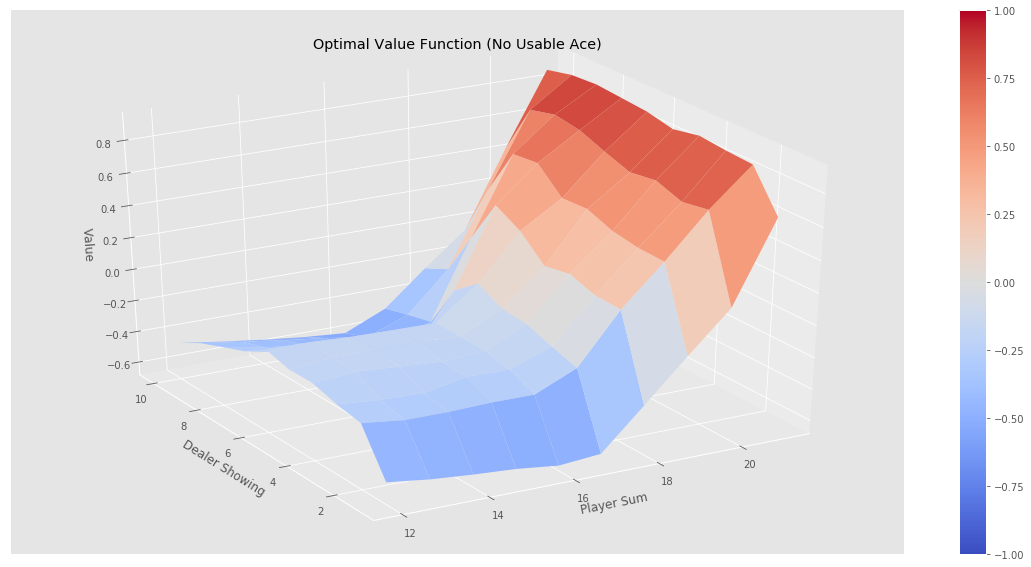

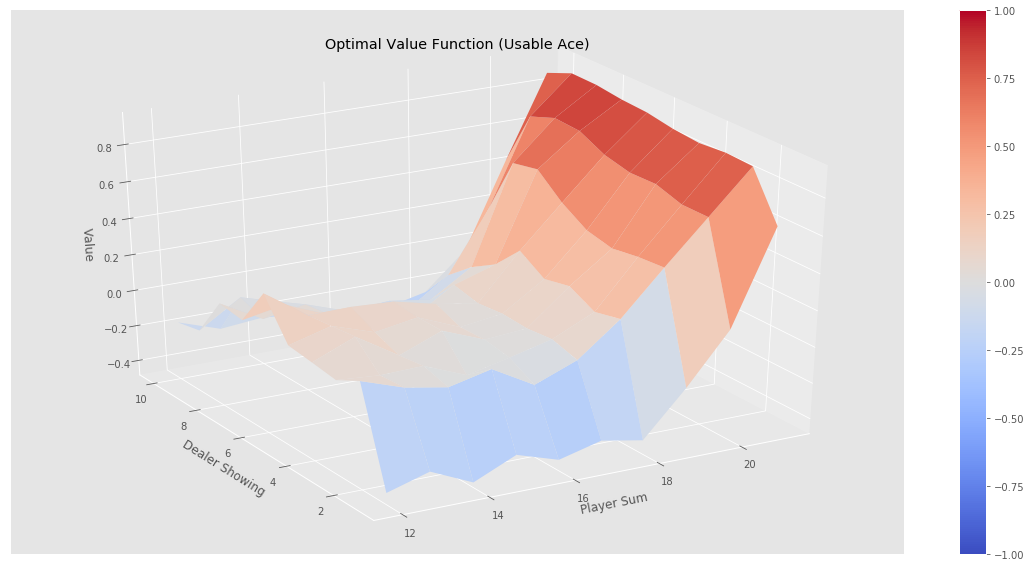

In [116]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")